This notebook is an adapted version of the original notebook designed by Sasha Rush: https://github.com/srush/GPTWorld



# GPTWorld Golf

The goal of this exercise is to write a prompt that can solve the movement of an AI in a grid world using prompting. You need to avoid walls, pick up a key, and then reach the goal.

You will need to use use an API Key for GroqCloud to run the exercise. GroqCloud is a platform providing free API access to models from the Llama series (constrained to some rate limits).

To obtain the API key, do the following:
1. visit [GroqCloud](https://console.groq.com/login)
2. Log in with your github or Google account, or sign up via email.
3. Once logged in, click on 'Api Keys' in the left panel.
4. Click 'Create API key'
5. Copy the key and paste it in the cell below


In [3]:
import os
os.environ

environ{'LDFLAGS': '-L/opt/homebrew/opt/ruby/lib',
        'MANPATH': '/opt/homebrew/share/man:',
        'TERM_PROGRAM': 'Apple_Terminal',
        'SHELL': '/bin/bash',
        'TERM': 'xterm-color',
        'CPPFLAGS': '-I/opt/homebrew/opt/ruby/include',
        'HOMEBREW_REPOSITORY': '/opt/homebrew',
        'TMPDIR': '/var/folders/yh/yrjpbrxn1_l703sz640w4ps40000gn/T/',
        'CONDA_SHLVL': '4',
        'GROQ_API_KEY': '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',
        'CONDA_PROMPT_MODIFIER': '(langchain) ',
        'TERM_PROGRAM_VERSION': '453',
        'OLDPWD': '/Users/koller/Documents/workspace',
        'TERM_SESSION_ID': '73007DB7-3F55-4AF0-B603-36D76249E379',
        'USER': 'koller',
        'CONDA_EXE': '/opt/anaconda3/bin/conda',
        'SSH_AUTH_SOCK': '/private/tmp/com.apple.launchd.etPsqyHr52/Listeners',
        'BASH_SILENCE_DEPRECATION_WARNING': '1',
        '_CE_CONDA': '',
        'CONDA_PREFIX_1': '/opt/anaconda3',
        'MAVEN_HOME': '/usr/l

In [4]:
ai_key = "TODO-FILL-IN"
groq_api_key = 'TODO-FILL-IN'

import os

if 'GROQ_API_KEY' in os.environ:
    groq_api_key = os.getenv('GROQ_API_KEY')
    print("Have Groq key.")

if 'OPENAI_API_KEY' in os.environ:
    ai_key = os.getenv('OPENAI_API_KEY')
    print("Have OpenAI key.")

Have Groq key.


In [ ]:
#@title Install (collapse me)
%%capture
!sudo apt-get install libcairo2-dev
!pip install -U git+https://github.com/chalk-diagrams/chalk openai pycairo tiktoken
!pip install groq

This cell can be ignored. It just imports the necessary libraries and sets up a prompt call.


In [ ]:
#@title Import (collapse me)
from dataclasses import dataclass
from chalk import *
from colour import Color
import inspect
import os
import openai
from typing import List, Tuple, Optional
from enum import Enum
import io
from IPython.display import Image
from contextlib import redirect_stdout
import imageio
import tiktoken
from groq import Groq

tab = "    "

os.environ['GROQ_API_KEY'] = groq_api_key
client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

def start(prompt):
    out = ""
    for chunk in client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[{
            "role": "user",
            "content": prompt,

        }],
        stream=True,
        temperature= 0.5
    ):

        content = chunk.choices[0].delta.content #chunk["choices"][0].get("delta", {}).get("content")
        if content is not None:
            out += content
            print(content, end="")
            yield out
    yield out


# use for prompting with an OpenAI key
def start_openai(prompt):
    out = ""
    for chunk in openai.chat.completions.create(
        model="gpt-4",
        messages=[{
            "role": "user",
            "content": prompt,

        }],
        stream=True,
        temperature= 0.5
    ):
        content = chunk.choices[0].delta.content
        if content is not None:
            out += content
            print(content, end="")
            yield out
    yield out

def num_tokens_from_string(string: str, encoding_name: str="gpt-4") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

## Game Code

This code creates a mini-game to play. It takes place on a hexagon. You are represented by a red circle. You need to first pick up a key represented by a purple triangle. You finally need to make it to the blue cross to finish the game. The actions below show each of the directions you can move.



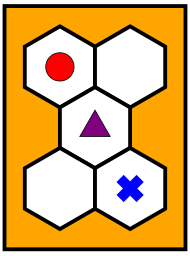

The positions on the game board are indexed as a tuple of y-coordinate and x-coordinate as shown below.

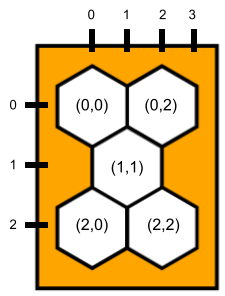

In [ ]:
#@title Game Code

# Possible Actions
class Actions(Enum):
    UPRIGHT = "UR"
    RIGHT = "R"
    DOWNRIGHT = "DR"
    DOWNLEFT = "DL"
    LEFT = "L"
    UPLEFT = "UL"
    PICKUP = "Pickup"

# Movements
change = {
    Actions.UPRIGHT : (-1, 1),
    Actions.RIGHT : (0, 2),
    Actions.DOWNRIGHT : (1, 1),
    Actions.DOWNLEFT : (1, -1),
    Actions.LEFT : (0, -2),
    Actions.UPLEFT : (-1, -1),
    Actions.PICKUP : (0, 0),
}
change_str = {action.value: change[action] for action in Actions}
def add(a, b):
    return a[0] + b[0], a[1] + b[1]

@dataclass
class Board:
    grid: List[str]
    player_pos: Tuple[int, int]
    flag_pos: Tuple[int, int]
    wall_pos:List[Tuple[int, int]]
    key_pos:Optional[Tuple[int, int]]

    def move(self, action: Actions) -> 'Board':
        "Move by creating a new board."
        d_m = change[action]
        if action == Actions.PICKUP:
            if self.player_pos == self.key_pos:
                return Board(self.grid, self.player_pos, self.flag_pos, self.wall_pos, None)
            else:
                return self

        new_player_pos = add(self.player_pos, d_m)
        # Out of bounds
        if new_player_pos[0] < 0 or new_player_pos[0] >= len(self.grid):
            return self
        if new_player_pos[1] < 0 or new_player_pos[1] >= len(self.grid[0]):
            return self
        # Can't move through walls
        if self.grid[new_player_pos[0]][new_player_pos[1]] == 'W':
            return self

        new_grid = [row[:] for row in self.grid] # Create a copy of the grid
        new_grid[self.player_pos[0]][self.player_pos[1]] = '.'
        new_grid[new_player_pos[0]][new_player_pos[1]] = '@'
        return Board(new_grid, new_player_pos, self.flag_pos, self.wall_pos, self.key_pos)

    def __str__(self) -> str:
        return '\n'.join(''.join(row) for i, row in enumerate(self.grid))

    @classmethod
    def create_empty_board(cls, size: Tuple[int, int], key_pos, flag_pos, init, wall_pos) -> 'Board':
        grid = [['.' if i % 2 == j % 2  else " " for i in range(size[1])] for j in range(size[0])]
        player_pos = init
        flag_pos = flag_pos
        grid[player_pos[0]][player_pos[1]] = '@'
        grid[flag_pos[0]][flag_pos[1]] = 'P'
        grid[key_pos[0]][key_pos[1]] = 'K'
        for pos in wall_pos:
            grid[pos[0]][pos[1]] = 'W'
        return cls(grid, player_pos, flag_pos, wall_pos, key_pos)

class Game:
    def __init__(self, init, flag, walls, key, boundary):
        "Create the version of the game that the AI sees."
        self.boundary = boundary
        self.board = Board.create_empty_board(boundary, key, flag, init, walls)
        self.original = self.board
        self.actions = []
        self.key = key

    def move(self, action):
        self.board = self.board.move(action)
        self.actions.append(action)

    @property
    def walls(self):
        return self.board.wall_pos

    def __repr__(self) -> str:
        walls = ",".join(map(str, self.board.wall_pos))
        return f"Game(init={self.board.player_pos}, flag={self.board.flag_pos}, walls= {self.board.wall_pos}, boundary= {self.boundary}, key= {self.board.key_pos})"

# This is the version of move that the AI can see.
def move(game, action, old_pos):
    # ACTIONS (must be legal)
    game.move(Actions(action))
    offset = change_str[action]
    pos = (old_pos[0] + offset[0], old_pos[1] + offset[1])
    assert 0 <= pos[0] < game.boundary[0]
    assert 0 <= pos[1] < game.boundary[1]
    assert pos not in game.walls
    if action == "Pickup":
        assert pos == game.key
    return pos

We can look at the board by drawing it.

In [ ]:
#@title Drawing code
def draw_board(grid, num=0):
    hex = regular_polygon(6, 1).rotate_by(1/12).line_width(0.5).fill_color(Color("white"))
    w = hex.get_envelope().width
    canvas = empty()
    for r, b in enumerate(grid):
        def show(v):
            if v == ".":
                return hex
            if v == "@":
                return hex + circle(0.35).fill_color(Color("red"))
            if v == "P":
                x = rectangle(0.25, 0.7).fill_color(Color("blue")).line_width(0)
                return hex + (x.rotate_by(0.25/2) + x.rotate_by(-0.25/2))
            if v == "K":
                return hex + triangle(0.75).fill_color(Color("purple"))
            if v == "W":
                return hex.fill_color(Color("black"))
            if v ==" ":
                return hex
        row = hcat(show(v) for i, v in enumerate(b[1 if r %2 else 0::2]))
        canvas += row.translate(w * 0.5 if r%2 else 0, 1.5 * r)
    canvas = canvas.center_xy().frame(0.5)
    canvas = rectangle(canvas.get_envelope().width, canvas.get_envelope().height).line_width(0.5).fill_color(Color("orange")) + canvas
    canvas.render(f"pic{num}.png", 256)
    return canvas



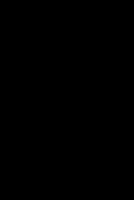

In [ ]:
# instantiate a new game and draw the board
game = Game(boundary=(6, 6), key=(0, 2), flag=(4, 4), init=(0, 0), walls=[(2, 2), (3,3)])
display(draw_board(game.board.grid))

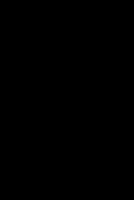

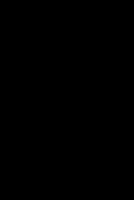

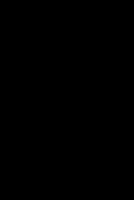

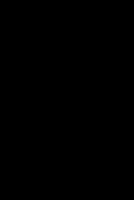

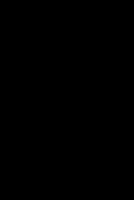

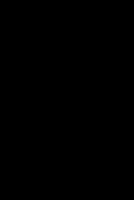

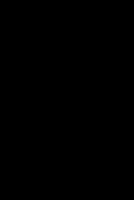

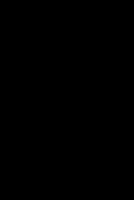

In [ ]:
# lets move across the board
game = Game(boundary=(6, 6), key=(0, 2), flag=(4, 4), init=(1, 1), walls=[(2, 2), (3,3), (2,4)])
display(draw_board(game.board.grid))
p = move(game, "UR", (1,1))
display(draw_board(game.board.grid))
p = move(game, "Pickup", p)
display(draw_board(game.board.grid))
p = move(game, "DL", p)
display(draw_board(game.board.grid))
p = move(game, "DL", p)
display(draw_board(game.board.grid))
p = move(game, "DR", p)
display(draw_board(game.board.grid))
p = move(game, "DR", p)
display(draw_board(game.board.grid))
p = move(game, "R", p)
display(draw_board(game.board.grid))

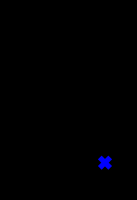

New player position: (1, 1)


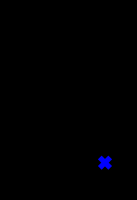

New player position: (0, 2)


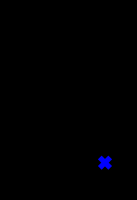

New player position: (0, 2)


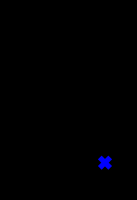

New player position: (1, 3)


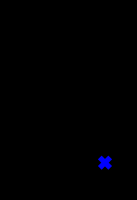

In [ ]:
game = Game(boundary=(5, 5), key=(0, 2), flag=(4, 4), init=(0, 0), walls=[(2, 2)])
display(draw_board(game.board.grid))

# move the player downright from starting position. New position is (1,1)
p = move(game, "DR", (0,0))
print('New player position: {}'.format(p))
display(draw_board(game.board.grid))

# move the player upright from (1,1)
p = move(game, "UR", p)
print('New player position: {}'.format(p))
display(draw_board(game.board.grid))

# perform pickup of the key
p = move(game, "Pickup", p)
print('New player position: {}'.format(p))
display(draw_board(game.board.grid))

# move the player downright
p = move(game, "DR", p)
print('New player position: {}'.format(p))
display(draw_board(game.board.grid))

### Invalid actions

Invalid actions will lead to assertion errors as demonstrated below

In [ ]:
# move the player upright from starting position.
game = Game(boundary=(5, 5), key=(0, 2), flag=(4, 4), init=(0, 0), walls=[(2, 2)])
move(game, "UR", (0,0))

AssertionError: 

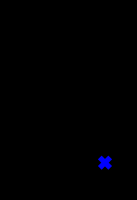

AssertionError: 

In [ ]:
# move the player downright from (1,1) (into the wall)
game = Game(boundary=(5, 5), key=(0, 2), flag=(4, 4), init=(0, 0), walls=[(1, 1)])
display(draw_board(game.board.grid))
move(game, "DR", (0,0))

In [ ]:
# perform pickup on a location that does not hold the key
game = Game(boundary=(5, 5), key=(0, 2), flag=(4, 4), init=(0, 0), walls=[(2, 2)])
move(game, "Pickup", (0,1))

AssertionError: 

### Parsing and executing LLM output
Your task will be to write a prompt that will make the LLM output code to play the game. The output of the LLM will be parsed and executed.

In [ ]:
def parse_llm_output(s):
  ps = s.split("\n")
  if len(ps) > 3 and not ps[-2].strip().startswith("#") and s.endswith("\n"):
    return True
  else: return  False

def my_example():
    b = Game(boundary=(3, 3), key=(1, 1), flag=(2, 2), init=(0, 0), walls=[])
    p = (0, 0)



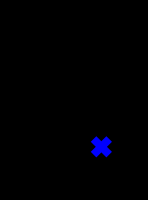

def my_example():
    b = Game(boundary=(3, 3), key=(1, 1), flag=(2, 2), init=(0, 0), walls=[])
    p = (0, 0)
    # This is a comment
    p = move(b, "DR", p)



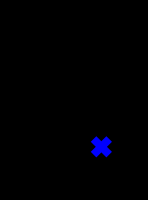

def my_example():
    b = Game(boundary=(3, 3), key=(1, 1), flag=(2, 2), init=(0, 0), walls=[])
    p = (0, 0)
    # This is a comment
    p = move(b, "DR", p)
    # This is a comment
    p = move(b, "Pickup", p)



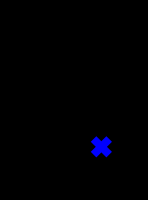

def my_example():
    b = Game(boundary=(3, 3), key=(1, 1), flag=(2, 2), init=(0, 0), walls=[])
    p = (0, 0)
    # This is a comment
    p = move(b, "DR", p)
    # This is a comment
    p = move(b, "Pickup", p)
    p = move(b, "DR", p)



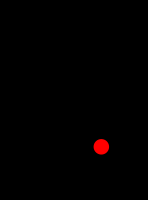

In [ ]:
example_llm_output = \
"""def my_example():
    b = Game(boundary=(3, 3), key=(1, 1), flag=(2, 2), init=(0, 0), walls=[])
    p = (0, 0)
    # This is a comment
    p = move(b, "DR", p)
    # This is a comment
    p = move(b, "Pickup", p)
    p = move(b, "DR", p)
"""


# parse and execute the example output
q = {}
i = 0
llm_outputs = [' '.join(example_llm_output.split(' ')[0:n+1]) for n in range(len(example_llm_output.split(' ')))]
for llm_output in llm_outputs:
  if parse_llm_output(llm_output):
    print(llm_output)
    exec(llm_output + "\n    return b\nq['board'] = my_example()")
    display(draw_board(q["board"].board.grid, i))
    i += 1





# Prompt Code

The puzzle is to write prompt code to make the model accomplish the task of playing the game. The following functions provide some scaffolding code for you.

You can fill this in and watch how the model moves around.

In [ ]:
#@title Make the Prompt I

# Wherever you see a #TODO comment is a good place to start modifying the prompt
# Remove the #TODO comments before passing the final prompt to model

def prompt(game):

    print(f"""
# TODO: DESCRIBE THE GAME
You are asked to generate code for playing a minigame which takes place on a hexagon.
A player needs to first pick up a key, and then make it to the flag to finish the game.
The actions below show each of the directions the player can move.

# TODO: DESCRIBE THE ACTIONS
change_str = {change_str}

# -------------
# EXAMPLE:
def example1():
    b = Game(init=(0, 0), flag=(2, 2), walls= [(2, 0)], boundary= (3, 3), key= (1, 1))
    p = (0, 0)

    # TODO ADD CODE
    p = move(b, "DR", p)

    # TODO ADD CODE
    p = move(b, "Pickup", p)

    # TODO ADD CODE
    p = move(b, "DR", p)
    return b
# ------------


# Contraints for this function:", {repr(game)}
# Please fill this in with code:
#
# The following function `my_example` instantiates a new Game called b with these constraints.
""")

Adding this example program to the prompt should help the model to get the required structure of the program right.

```
#-------------
# EXAMPLE:
def example1():
    b = Game(init=(0, 0), flag=(2, 2), walls= [(2, 0)], boundary= (3, 3), key= (1, 1))
    p = (0, 0)

    # TODO ADD CODE
    p = move(b, "DR", p)

    # TODO ADD CODE
    p = move(b, "Pickup", p)

    # TODO ADD CODE
    p = move(b, "DR", p)
    return b
# ------------
```

Adding information about how the `move()` method works (including the constraints for valid actions) might help as well

```
This is the function that is used to move the player on the game board:

def move(game, action, old_pos):
    # ACTIONS (must be legal)
    game.move(Actions(action))
    offset = change_str[action]
    pos = (old_pos[0] + offset[0], old_pos[1] + offset[1])
    assert 0 <= pos[0] < game.boundary[0]
    assert 0 <= pos[1] < game.boundary[1]
    assert pos not in game.walls
    if action == "Pickup":
        assert pos == game.key
    return pos
```

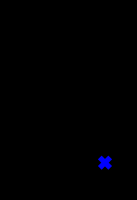


# TODO: DESCRIBE THE GAME
You are asked to generate code for playing a minigame which takes place on a hexagon.
A player needs to first pick up a key, and then make it to the flag to finish the game.
The actions below show each of the directions the player can move.

# TODO: DESCRIBE THE ACTIONS
change_str = {'UR': (-1, 1), 'R': (0, 2), 'DR': (1, 1), 'DL': (1, -1), 'L': (0, -2), 'UL': (-1, -1), 'Pickup': (0, 0)}

# -------------
# EXAMPLE:
def example1():
    b = Game(init=(0, 0), flag=(2, 2), walls= [(2, 0)], boundary= (3, 3), key= (1, 1))
    p = (0, 0)

    # TODO ADD CODE
    p = move(b, "DR", p)

    # TODO ADD CODE
    p = move(b, "Pickup", p)

    # TODO ADD CODE
    p = move(b, "DR", p)
    return b
# ------------


# Contraints for this function:", Game(init=(0, 0), flag=(4, 4), walls= [(1, 1)], boundary= (5, 5), key= (3, 1))
# Please fill this in with code:
#
# The following function `my_example` instantiates a new Game called b with these constraints.




In [ ]:
# Easy
#game = Game(boundary=(3, 3), key=(1, 1), flag=(2, 2), init=(0, 0), walls=[])

# Medium
game = Game(boundary=(5, 5), key=(3, 1), flag=(4, 4), init=(0, 0), walls=[(1, 1)])

# Hard (This is the main one)
#game = Game(boundary=(8, 15), key=(3, 1), flag=(7, 13), init=(0, 0), walls=[(2, 2), (1, 1), (5, 3), (1, 11), (5, 5), (6, 6), (6, 10), (2, 6), (4, 12)])

# Evil
#game = Game(boundary=(8, 15), key=(5, 1), flag=(7, 13), init=(0, 0), walls=[(2, 2), (3, 3), (4, 2), (1, 1), (2, 4), (7, 11), (5, 3), (1, 11), (5, 5), (6, 6), (6, 10), (2, 6), (4, 12)])

display(draw_board(game.board.grid))

f = io.StringIO()
with redirect_stdout(f):
    ex = 0
    prompt(game)
my_prompt = f.getvalue()
print(my_prompt)

def my_example():
    b = Game(init=(0, 0), flag=(2, 2), walls= [], boundary= (3, 3), key= (1, 1))
    p = (0, 0)


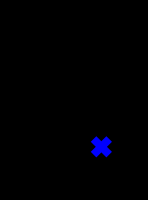

    # There are no walls, so the player can move freely
    # The key is in (1, 1), so Pickup can only be performed there



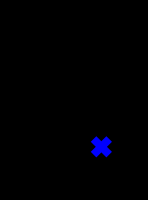

    # TODO ADD CODE
    # Cannot perform Pickup action because the player is not in the same location as the key.
    # No walls, so player can move to position (1, 1)
    # Performing DR to move from (0, 0) to (1, 1).
    p = move

KeyboardInterrupt: 

In [ ]:
# Run an LLM and execute it as it runs.
q = {}
i = 0

for prefix in start_openai(my_prompt):
    if parse_llm_output(prefix):
        exec(prefix + "\n    return b\nq['board'] = my_example()")
        display(draw_board(q["board"].board.grid, i))
        i += 1

# Animate the outputs as a GIF
def animate(i):
    images = []
    for i in range(i):
        images.append(imageio.v2.imread(f"pic{i}.png"))
    return imageio.v2.mimsave('movie.gif', images, **{ 'duration': 0.5 })
animate(i)
display(Image("movie.gif"))


# Print the number of tokens used
print("Input Tokens:", num_tokens_from_string(my_prompt))
print("Output Tokens:", num_tokens_from_string(prefix))

### Make the Prompt II

Adding more examples (that illustrate possible actions on possible game boards) should help. Below is a function that generates python code for few-shot examples.

In [ ]:
# This function generates python code for few-shot examples
# You can modify it to customize the output you expect from the model

def make_fun(board, actions):
    out = tab + "p = " + str(board.player_pos)
    out += '\n' + tab + '# The walls are in ' + str(board.wall_pos) + ', so the player cannot move there'
    out += '\n' + tab + '# The key is in ' + str(board.key_pos) + ', so Pickup can only be performed there'
    positions = [board.player_pos]
    for i, action in enumerate(actions):
        new_board = board.move(action)
        positions.append(new_board.player_pos)
        stuff = ''

        def _move(pos1, pos2):
          return (pos1[0] + pos2[0], pos1[1] + pos2[1])

        if action.value == 'Pickup':
           stuff = '# Perform Pickup action because the player is in the same location as the key'
        else:
          stuff = '# Cannot perform Pickup action because the player is not in the same location as the key.\n\t#The walls are in {}, so player can move to position {}\n\t#Performing {} to move from {} to {}.'.format(str(board.wall_pos), _move(positions[i], change[action]), action.value, positions[i], _move(positions[i], change[action]))
        out += f"""

    # TODO ADD CODE
    {stuff}
    p = move(b, "{action.value}", p)"""
        board = new_board
    return out

board = Game(boundary=(3, 3), key=(1, 1), flag=(2, 2), init=(0, 0), walls=[(2, 0)])
actions = [Actions.DOWNRIGHT, Actions.PICKUP, Actions.DOWNRIGHT]

print(make_fun(board.board, actions))


    p = (0, 0)
    # The walls are in [(2, 0)], so the player cannot move there
    # The key is in (1, 1), so Pickup can only be performed there

    # TODO ADD CODE
    # Cannot perform Pickup action because the player is not in the same location as the key.
	#The walls are in [(2, 0)], so player can move to position (1, 1)
	#Performing DR to move from (0, 0) to (1, 1).
    p = move(b, "DR", p)

    # TODO ADD CODE
    # Perform Pickup action because the player is in the same location as the key
    p = move(b, "Pickup", p)

    # TODO ADD CODE
    # Cannot perform Pickup action because the player is not in the same location as the key.
	#The walls are in [(2, 0)], so player can move to position (2, 2)
	#Performing DR to move from (1, 1) to (2, 2).
    p = move(b, "DR", p)


In [ ]:
# This function can directly add few shot examples generated by make_fun() above (in the right format) to the prompt. You don't need to edit it.

ex = 0
def example(game, actions):
  global ex
  ex += 1
  print(f"""
#-------------
# EXAMPLE:
def example{ex}():
    b = {repr(game)}
{make_fun(game.board, actions)}
    return b
# ------------
""")


example(game, actions)


#-------------
# EXAMPLE:
def example1():
    b = Game(init=(0, 0), flag=(4, 4), walls= [(1, 1)], boundary= (5, 5), key= (3, 1))
    p = (0, 0)
    # The walls are in [(1, 1)], so the player cannot move there
    # The key is in (3, 1), so Pickup can only be performed there

    # TODO ADD CODE
    # Cannot perform Pickup action because the player is not in the same location as the key.
	#The walls are in [(1, 1)], so player can move to position (1, 1)
	#Performing DR to move from (0, 0) to (1, 1).
    p = move(b, "DR", p)

    # TODO ADD CODE
    # Perform Pickup action because the player is in the same location as the key
    p = move(b, "Pickup", p)

    # TODO ADD CODE
    # Cannot perform Pickup action because the player is not in the same location as the key.
	#The walls are in [(1, 1)], so player can move to position (1, 1)
	#Performing DR to move from (0, 0) to (1, 1).
    p = move(b, "DR", p)
    return b
# ------------



In [ ]:
ex = 0

def prompt(game):
    print(f"""
# DESCRIPTION OF THE GAME
You are asked to generate code to play a game, which takes place on a hexagon referred to as GameBoard.
There is a player, which is placed on the GameBoard and can be moved based on the code you produce.
The goal is to first move the player to the location of the key, pick up the key, and then move them to the flag to end the game.
There are some pre-defined actions that can be executed on the GameBoard in order to move the player and let them pick up the key.
The GameBoard contains walls, which the player mustn't be moved into.
The GameBoard of Game(boundary=(int ys, int xs)) has y coordinates in the range from 0 to ys, and x coordinates in the range from 0 to xs.
The player cannot move to positions outside the range of these coordinates.


# DESCRIPTION OF THE ACTIONS

The actions that the player can perform are:
'UR' = Player's y coordinate is decreased by one and x coordinate is increased by one. If current position is (1,1), new position is (0,2).
'R' = Player's y coordinate stays the same and x coordinate is increased by two. If current position is (1,1), new position is (1,3).
'UL' = Player's y coordinate is decreased by one and x coordinate is decreased by one. If current position is (1,1), new position is (0,0).
'L' = Player's y coordinate stays the same and x coordinate is decreased by two. If current position is (2,2), new position is (2,0).
'DR' = Player's y coordinate is increased by one and x coordinate is increased by one. If current position is (1,1), new position is (2,2).
'DL' = Player's y coordinate is increased by one and x coordinate is decreased by one. If current position is (1,1), new position is (2,0).
'Pickup' = pickup: The player picks up the key. Can only be performed at the position where the key is located. If current position is (1,1), new position is (1,1).


The player cannot move outside the boundaries of the game board.
The player cannot move into walls.
The player can only perform Pickup if they are in the same location as the key.

Plan:
First, walk to key an perform Pickup. Avoid walls.
Then, move to flag. Avoid walls.
""")


    # Create a few shot example (you may not need this)
    board = Game(boundary=(3, 3), key=(1, 1), flag=(2, 2), init=(0, 0), walls=[(2, 0)])
    actions = [Actions.DOWNRIGHT, Actions.PICKUP, Actions.DOWNRIGHT]
    example(board, actions)

    # Below you can add more few-shot examples
    board = Game(boundary=(6, 6), key=(0, 2), flag=(4, 4), init=(1, 1), walls=[(2, 2), (3,3), (2,4)])
    actions = [Actions.UPRIGHT, Actions.PICKUP, Actions.DOWNLEFT, Actions.DOWNLEFT, Actions.DOWNRIGHT, Actions.DOWNRIGHT, Actions.RIGHT]
    example(board, actions)


    # Test case
    print(f"""
# ----
# TODO: ADD any custom example code
#---
# TODO: FINAL description.

# Contraints for this function:", {repr(game)}
# Please fill this in with code like the examples above:
#
# The following function `my_example` instantiates a Game called b with these constraints.

""")


This code lets you make a game and see the output for a prompt for that game. There are easy, medium, and hard games.

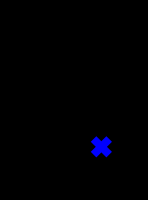


# DESCRIPTION OF THE GAME
You are asked to generate code to play a game, which takes place on a hexagon referred to as GameBoard.
There is a player, which is placed on the GameBoard and can be moved based on the code you produce.
The goal is to first move the player to the location of the key, pick up the key, and then move them to the flag to end the game.
There are some pre-defined actions that can be executed on the GameBoard in order to move the player and let them pick up the key.
The GameBoard contains walls, which the player mustn't be moved into.
The GameBoard of Game(boundary=(int ys, int xs)) has y coordinates in the range from 0 to ys, and x coordinates in the range from 0 to xs.
The player cannot move to positions outside the range of these coordinates.


# DESCRIPTION OF THE ACTIONS

The actions that the player can perform are:
'UR' = Player's y coordinate is decreased by one and x coordinate is increased by one. If current position is (1,1), new position is (0,2).
'R' = 

In [ ]:
# Easy
game = Game(boundary=(3, 3), key=(1, 1), flag=(2, 2), init=(0, 0), walls=[])

# Medium
#game = Game(boundary=(5, 5), key=(3, 1), flag=(4, 4), init=(0, 0), walls=[(1, 1)])

# Hard (This is the main one)
#game = Game(boundary=(8, 15), key=(3, 1), flag=(7, 13), init=(0, 0), walls=[(2, 2), (1, 1), (5, 3), (1, 11), (5, 5), (6, 6), (6, 10), (2, 6), (4, 12)])

# Evil
#game = Game(boundary=(8, 15), key=(5, 1), flag=(7, 13), init=(0, 0), walls=[(2, 2), (3, 3), (4, 2), (1, 1), (2, 4), (7, 11), (5, 3), (1, 11), (5, 5), (6, 6), (6, 10), (2, 6), (4, 12)])

display(draw_board(game.board.grid))

f = io.StringIO()
with redirect_stdout(f):
    ex = 0
    prompt(game)
my_prompt = f.getvalue()
print(my_prompt)

In [ ]:
# Run an LLM and execute it as it runs.
q = {}
i = 0
for prefix in start(my_prompt):
    if parse_llm_output(prefix):
        exec(prefix + "\n    return b\nq['board'] = my_example()")
        display(draw_board(q["board"].board.grid, i))
        i += 1

# Animate the outputs as a GIF
def animate(i):
    images = []
    for i in range(i):
        images.append(imageio.v2.imread(f"pic{i}.png"))
    return imageio.v2.mimsave('movie.gif', images, **{ 'duration': 0.5 })
animate(i)
display(Image("movie.gif"))


# Print the number of tokens used
print("Input Tokens:", num_tokens_from_string(my_prompt))
print("Output Tokens:", num_tokens_from_string(prefix))

Here is the code for the `my_example` function:
```
def my_example():


SyntaxError: invalid syntax (<string>, line 1)